In [17]:
# pip install --pre openforis-whisp

In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import contextily as ctx
import geopandas as gpd
from shapely.geometry import mapping
import os
import rasterio
from rasterstats import zonal_stats
import pandas as pd
import tempfile
from docx import Document
from docx.shared import Inches, Pt
from docx.enum.table import WD_TABLE_ALIGNMENT
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx2pdf import convert




In [2]:
import metodos_mixtos as mmc
# from metodos_mixtos import importaciones_mapas import *
from metodos_mixtos import mapas
from metodos_mixtos import mapas_raster

## Loading data 

In [3]:
psah=gpd.read_file(r"C:\Users\laura\OneDrive - Vestigium Métodos Mixtos Aplicados SAS\MMC - General - SDP - Monitoreo de Bosques\Shapes PSA\areas_priorizadas_psah.shp")

In [4]:
aoi=gpd.read_file(r"C:\Users\laura\OneDrive - Vestigium Métodos Mixtos Aplicados SAS\MMC - General - SDP - Monitoreo de Bosques\AOI-Bogota-Colombia\bog-area-estudio.shp")

In [5]:
psah = psah.to_crs(epsg=4326) 
aoi=aoi.to_crs(epsg=4326)

<Axes: >

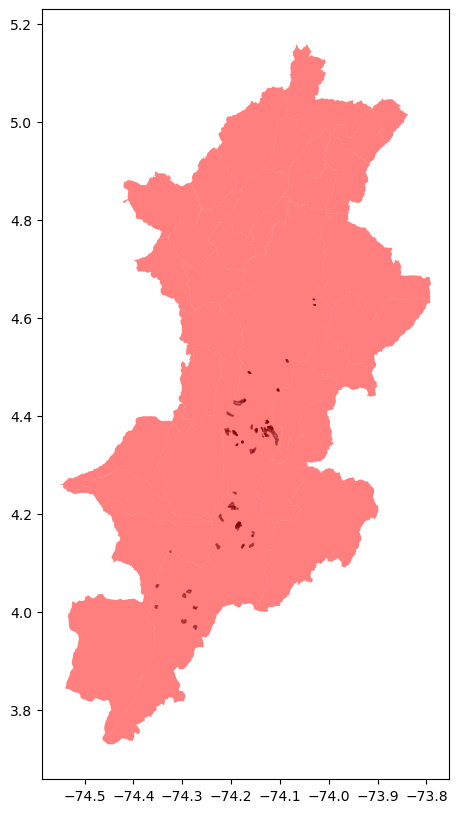

In [6]:
plot = psah.plot(figsize=(10, 10), edgecolor='black', alpha=0.5)
aoi.plot(ax=plot, color='red', alpha=0.5)

In [7]:
psah.head()

,OBJECTID,lotCodigo,ID,PreDirecc,Tipo_Area,Estado,Area_ha,Obs,Shape_Leng,Shape_Area,geometry
0,9.0,102909000022,085,MONTE BELLO- SAN BENITO,1,1,156.030179,None,10812.067744,1.558391e+06,"POLYGON ((-74.11192 4.36883, -74.11177 4.36872..."
1,18.0,102910000026,140,VDA CENTRO PIEDRA GRANDE ARRAYAN,1,1,0.277688,None,580.102470,2.773522e+03,"MULTIPOLYGON (((-74.13519 4.35873, -74.13511 4..."
2,35.0,102910000026,140,VDA CENTRO PIEDRA GRANDE ARRAYAN,1,1,0.174623,None,288.936418,1.744118e+03,"POLYGON ((-74.13351 4.35802, -74.1335 4.35806,..."
3,37.0,102909000005,203,MICANIA II-SAN BENITO,1,1,2.934480,EUCALIPTOS AISLADOS,1272.100361,2.930926e+04,"POLYGON ((-74.13102 4.37005, -74.131 4.37007, ..."
4,40.0,102909000005,203,MICANIA II-SAN BENITO,1,1,0.597814,None,740.669831,5.970918e+03,"POLYGON ((-74.13442 4.36961, -74.13441 4.36958..."


<Axes: >

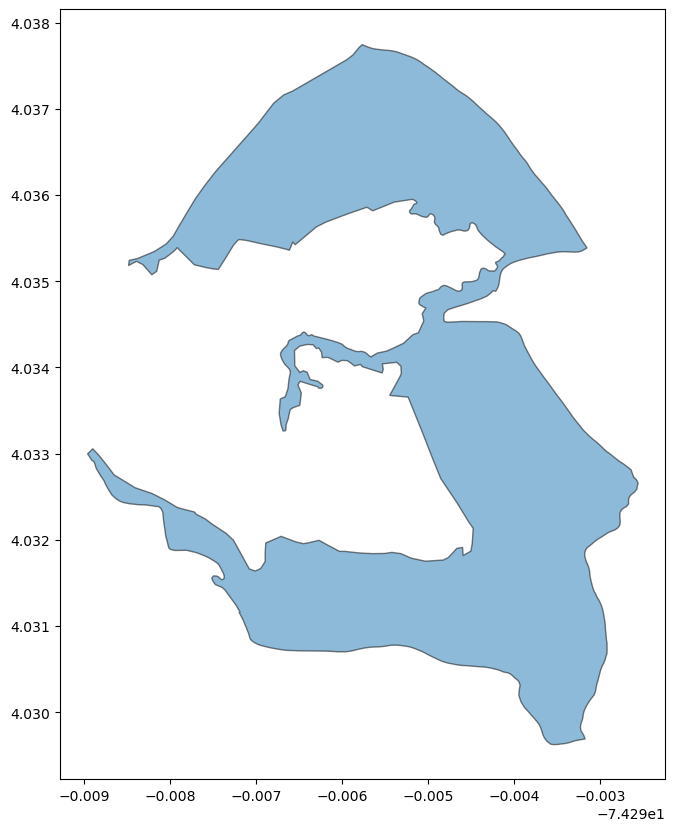

In [8]:
id1=psah[psah["lotCodigo"] == "109103000027"]
id1.plot(figsize=(10, 10), edgecolor='black', alpha=0.5)

In [9]:
id1.to_file(r"C:\Users\laura\Downloads\Ensayo PSAH\psah_lote_109103000027.kml", driver="KML")

### Raster clipping

In [10]:
mapas_raster.raster_clipping(r"C:\Users\laura\OneDrive - Vestigium Métodos Mixtos Aplicados SAS\MMC - General - SDP - Monitoreo de Bosques\AOI-Bogota-Colombia\bog-area-estudio.shp", r"C:\Users\laura\OneDrive - Vestigium Métodos Mixtos Aplicados SAS\MMC - General - geoinfo\deforestacion\hansen\hansen_colombia\Hansen Colombia 2024\hansen_treecover_Colombia_2024_mosaico.tif",  r"C:\Users\laura\Downloads\Ensayo PSAH\hansen_treecover_SDP_2024.tif")

'C:\\Users\\laura\\Downloads\\Ensayo PSAH\\hansen_treecover_SDP_2024.tif'

## Parameters

In [11]:
# Rutas de entrada
hansen_path = 'C:\\Users\\laura\\Downloads\\Ensayo PSAH\\hansen_treecover_SDP_2024.tif'

# Parámetros
nombre_columna = "lotCodigo"  # o "id", según tu shapefile
año_inicio = 2000 #Fecha (con días y mes y donde aplique lookback days) (si cae en páramo )  NDVI como complemento de cobertura boscosa 
año_fin = 2024
carpeta_salida = "reportes_deforestacion"

## Functions

In [12]:

def plot_deforestation_map(
    raster_path,
    gdf,
    names_column,
    name_of_area,
    year_start,
    year_end,
    output_folder=".",
    basemap=False
):
    # Nombre de archivo de salida
    safe_name = str(name_of_area).replace(" ", "_").replace("/", "_")
    output_path = os.path.join(
        output_folder,
        f"deforestacion_{safe_name}_{year_start}_a_{year_end}.png"
    )

    # Crear shapefile y raster temporales
    temp_dir = tempfile.mkdtemp()
    temp_shp = os.path.join(temp_dir, "temp_shape.shp")
    temp_tif = os.path.join(temp_dir, "temp_raster_clip.tif")
    gdf.to_file(temp_shp)

    # Recorte
    mapas_raster.raster_clipping(temp_shp, raster_path, temp_tif)

    # Leer raster recortado
    with rasterio.open(temp_tif) as src:
        raster_crs = src.crs
        if gdf.crs != raster_crs:
            gdf = gdf.to_crs(raster_crs)

        band_count = src.count
        start_code = year_start - 2000
        end_code = year_end - 2000

        if band_count == 1:
            # Raster solo de lossyear
            lossyear = src.read(1)
            loss_mask = ((lossyear >= start_code) & (lossyear <= end_code)).astype(np.uint8) * 255
            preserved_mask = (lossyear == 0).astype(np.uint8) * 255

        elif band_count >= 3:
            # Raster Hansen original (treecover2000, loss, lossyear)
            treecover2000 = src.read(1)
            loss = src.read(2)
            lossyear = src.read(3)
            valid_forest = treecover2000 > 0
            loss_mask = (
                valid_forest & (loss == 1) &
                (lossyear >= start_code) & (lossyear <= end_code)
            ).astype(np.uint8) * 255
            preserved_mask = (
                valid_forest &
                ((loss == 0) | (lossyear > end_code))
            ).astype(np.uint8) * 255
        else:
            raise ValueError("El raster debe tener 1 banda (lossyear) o 3 bandas (treecover2000, loss, lossyear).")

        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(preserved_mask, cmap='Greens', extent=extent)
    ax.imshow(loss_mask, cmap='Reds', extent=extent, alpha=0.6)

    gdf.boundary.plot(ax=ax, color='black', linewidth=1)
    for _, row in gdf.iterrows():
        ax.annotate(
            text=row[names_column],
            xy=(row.geometry.centroid.x, row.geometry.centroid.y),
            ha='center', fontsize=5, color='black'
        )

    legend1 = mpatches.Patch(color='green', label=f'Bosque en {year_end}')
    legend2 = mpatches.Patch(color='red', label=f'Pérdida {year_start}–{year_end}')
    ax.legend(handles=[legend1, legend2], loc='lower left')

    ax.set_title(f'Pérdida de bosque entre {year_start} y {year_end} en {name_of_area}')
    ax.set_xticks([])
    ax.set_yticks([])

    plt.savefig(output_path, bbox_inches='tight', dpi=400)
    plt.close()

    print(f"Mapa guardado en: {output_path}")
    return output_path 

In [13]:
def def_anual(gdf, raster_path, year_min=2000, year_max=2024):
    """
    Calcula la deforestación anual (ha) por polígono
    usando Hansen multibanda y recorte previo.
    """
    # Códigos Hansen
    start_code = year_min - 2000
    end_code = year_max - 2000

    # Archivos temporales
    temp_dir = tempfile.mkdtemp()
    temp_shp = os.path.join(temp_dir, "temp_shape.shp")
    temp_tif = os.path.join(temp_dir, "temp_raster_clip.tif")
    gdf.to_file(temp_shp)

    # Recorte del raster
    mapas_raster.raster_clipping(temp_shp, raster_path, temp_tif)

    # Leer y filtrar raster
    with rasterio.open(temp_tif) as src:
        treecover2000 = src.read(1)
        loss = src.read(2)
        lossyear = src.read(3)

        # Máscara de pérdida válida
        mask_loss = (
            (treecover2000 > 0) &
            (loss == 1) &
            (lossyear >= start_code) &
            (lossyear <= end_code)
        )

        lossyear_masked = np.where(mask_loss, lossyear, 0)

        # Guardar el profile aquí dentro del with
        profile = src.profile

    # Guardar raster filtrado
    profile.update(dtype=rasterio.uint8, count=1)
    temp_filtered = os.path.join(temp_dir, "filtered_lossyear.tif")
    with rasterio.open(temp_filtered, "w", **profile) as dst:
        dst.write(lossyear_masked.astype(rasterio.uint8), 1)

    # Calcular estadísticas zonales por año
    stats = zonal_stats(
        gdf, temp_filtered,
        stats=['count'],
        categorical=True,
        nodata=0
    )

    results = []
    for i, stat in enumerate(stats):
        for year_code, pixel_count in stat.items():
            if isinstance(year_code, int) and year_code > 0:
                year = 2000 + year_code
                area_ha = pixel_count * (30 * 30) / 10000
                results.append({
                    'id': gdf.iloc[i].get('id', i),
                    'Año': year,
                    'Hectáreas deforestadas (ha)': area_ha
                })

    df_result = pd.DataFrame(results)

    # Mensaje si no hay deforestación detectada
    if df_result.empty or df_result["Hectáreas deforestadas (ha)"].sum() == 0:
        print("⚠ No se detectó deforestación en el rango de años especificado.")

    return df_result


In [14]:
# Leer raster y obtener CRS
with rasterio.open(hansen_path) as src:
    raster_crs = src.crs

print(f"CRS del raster: {raster_crs}")

CRS del raster: EPSG:4326


In [15]:
print(f"CRS del polígono: {psah.crs}")

CRS del polígono: EPSG:4326


In [16]:
plot_deforestation_map(
    raster_path=hansen_path,
    gdf=id1,
    names_column="lotCodigo",
    name_of_area=id1["PreDirecc"].iloc[0],
    year_start=año_inicio,
    year_end=año_fin,
    output_folder=r"C:\Users\laura\Downloads\Ensayo PSAH\Mapas"
)


Mapa guardado en: C:\Users\laura\Downloads\Ensayo PSAH\Mapas\deforestacion_LA_ESPERANZA-LAS_VEGAS_2000_a_2024.png


'C:\\Users\\laura\\Downloads\\Ensayo PSAH\\Mapas\\deforestacion_LA_ESPERANZA-LAS_VEGAS_2000_a_2024.png'

In [17]:
def_anual(gdf=id1,
          raster_path=hansen_path,
          year_max=año_fin,
          year_min=año_inicio)

⚠ No se detectó deforestación en el rango de años especificado.


""


## Mapas de deforestación (por lote)

In [18]:
# Función: Mapa de ubicación dentro del AOI
def plot_location_map(aoi_gdf, poly_gdf, output_path):
 # Reproyección solo para el gráfico con contextily
    aoi_proj = aoi_gdf.to_crs(epsg=3857)
    poly_proj = poly_gdf.to_crs(epsg=3857)

    # Graficar
    fig, ax = plt.subplots(figsize=(8, 8))
    aoi_proj.boundary.plot(ax=ax, color="white", linewidth=1)
    poly_proj.boundary.plot(ax=ax, color="red", linewidth=2)

# Ajustar límites al AOI para evitar que contextily haga zoom raro
    ax.set_xlim(aoi_proj.total_bounds[[0, 2]])
    ax.set_ylim(aoi_proj.total_bounds[[1, 3]])

# Añadir mapa base después de definir límites
    ctx.add_basemap(ax, crs=3857, source=ctx.providers.Esri.WorldImagery)

    # Opcional: título y estética
    ax.set_title("Ubicación del lote", fontsize=12)
    ax.set_xticks([]); ax.set_yticks([])

    # Guardar
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.close()

In [ ]:
# Crear reporte (no incluye tabla cuando no hay pérdida)
def crear_reporte(titulo, descripcion, tabla_def, img_context, img_deforestation, output_path):
    import re

    IMG_MAX_HEIGHT_IN = 4.0  # baja a 2.8 si aún ves saltos

    # ---- Helpers ----
    def _sum_ha(df: pd.DataFrame) -> float:
        """Suma la columna de hectáreas (detecta 'ha', 'hectáreas', etc.)."""
        if df is None or df.empty:
            return 0.0
        ha_cols = [c for c in df.columns if re.search(r'\bha\b|hect', str(c), re.I)]
        if not ha_cols:
            # fallback: primera numérica
            num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
            if not num_cols:
                return 0.0
            ha_col = num_cols[0]
        else:
            ha_col = ha_cols[0]
        return pd.to_numeric(df[ha_col], errors='coerce').fillna(0).sum()

    def _to_anual(df: pd.DataFrame) -> pd.DataFrame:
        """Normaliza a columnas ['Año','ha'] si viene con nombres diferentes."""
        if df is None or df.empty:
            return pd.DataFrame(columns=['Año', 'Hectáreas (ha)'])
        # detectar columnas
        ycol = None
        for c in df.columns:
            if re.search(r'a[ñn]o|anio|year|loss[_ ]?year', str(c), re.I):
                ycol = c; break
        ha_col = None
        for c in df.columns:
            if re.search(r'\bha\b|hect|area_?ha', str(c), re.I):
                ha_col = c; break
        out = df.copy()
        if ycol is not None and ha_col is not None:
            out = out.rename(columns={ycol: 'Año', ha_col: 'Hectáreas (ha)'})[['Año', 'Hectáreas (ha)']]
        else:
            # ancho: columnas con año en el nombre
            pairs = []
            for c in df.columns:
                m = re.search(r'(19|20)\d{2}', str(c))
                if m:
                    y = int(m.group(0))
                    v = pd.to_numeric(df[c], errors='coerce').fillna(0).sum()
                    pairs.append((y, v))
            out = pd.DataFrame(pairs, columns=['Año', 'Hectáreas (ha)']) if pairs else pd.DataFrame(columns=['Año','Hectáreas (ha)'])
        # limpiar tipos
        if not out.empty:
            out['Año'] = pd.to_numeric(out['Año'], errors='coerce').astype('Int64')
            out['Hectáreas (ha)']  = pd.to_numeric(out['Hectáreas (ha)'],  errors='coerce').fillna(0.0)
            out = out.dropna(subset=['Año']).astype({'Año':'int'}).groupby('Año', as_index=False)['Hectáreas (ha)'].sum()
            out = out.sort_values('Año')
        return out

    # Documento 
    doc = Document()
    section = doc.sections[0]
    section.page_width, section.page_height = Inches(8.5), Inches(11)
    section.left_margin = section.right_margin = section.top_margin = section.bottom_margin = Inches(0.75)

    normal = doc.styles['Normal'].paragraph_format
    normal.space_before = Pt(0); normal.space_after = Pt(6); normal.line_spacing = 1.08
    h1 = doc.styles['Heading 1'].paragraph_format; h1.space_before = Pt(0); h1.space_after = Pt(6)
    h2 = doc.styles['Heading 2'].paragraph_format; h2.space_before = Pt(8); h2.space_after = Pt(4); h2.keep_with_next = True

    # Título y descripción
    p = doc.add_heading(titulo, level=1); p.alignment = WD_ALIGN_PARAGRAPH.CENTER
    p = doc.add_paragraph(descripcion); p.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY; p.paragraph_format.space_after = Pt(8)

    # Mapa de ubicación
    p = doc.add_heading("Mapa de ubicación", level=2); p.paragraph_format.keep_with_next = True
    pic = doc.add_paragraph(); run = pic.add_run(); run.add_picture(img_context, height=Inches(IMG_MAX_HEIGHT_IN))
    pic.alignment = WD_ALIGN_PARAGRAPH.CENTER; pic.paragraph_format.space_after = Pt(6)

    # Deforestación
    p = doc.add_heading("Deforestación", level=2); p.paragraph_format.keep_with_next = True

    # ¿Hay pérdida? (si no, no se muestra la tabla)
    hay_perdida = _sum_ha(tabla_def) > 0

    if hay_perdida:
        anual = _to_anual(tabla_def)
        subt = doc.add_heading("Deforestación anual (ha)", level=2); subt.paragraph_format.keep_with_next = True

        table = doc.add_table(rows=1, cols=2); table.style = "Table Grid"; table.alignment = WD_TABLE_ALIGNMENT.CENTER
        hdr = table.rows[0].cells; hdr[0].text = "Año"; hdr[1].text = "Hectáreas (ha)"
        for c in hdr:
            if c.paragraphs and c.paragraphs[0].runs: c.paragraphs[0].runs[0].bold = True
            c.paragraphs[0].paragraph_format.space_before = Pt(0); c.paragraphs[0].paragraph_format.space_after = Pt(0)

        for _, r in anual.iterrows():
            cells = table.add_row().cells
            cells[0].text = str(int(r['Año']))
            cells[1].text = f"{float(r['Hectáreas (ha)']):.2f}"
            for c in cells:
                pc = c.paragraphs[0]; pc.paragraph_format.space_before = Pt(0); pc.paragraph_format.space_after = Pt(0); pc.paragraph_format.keep_together = True

        # pequeño espacio antes del mapa
        doc.add_paragraph().paragraph_format.space_after = Pt(4)
    else:
        p = doc.add_paragraph("No se detectó pérdida de cobertura arbórea en el rango de tiempo especificado.")
        p.paragraph_format.space_after = Pt(6)

    # Mapa de deforestación (siempre)
    p = doc.add_heading("Mapa de deforestación", level=2); p.paragraph_format.keep_with_next = True
    pic = doc.add_paragraph(); run = pic.add_run(); run.add_picture(img_deforestation, height=Inches(IMG_MAX_HEIGHT_IN))
    pic.alignment = WD_ALIGN_PARAGRAPH.CENTER; pic.paragraph_format.space_after = Pt(0)

    doc.save(output_path)



In [ ]:
import os, re, tempfile, shutil, unicodedata
import win32com.client as win32  

def _safe_ascii_name(name: str) -> str:
    n = unicodedata.normalize("NFKD", name)
    n = "".join(c for c in n if not unicodedata.combining(c))
    n = re.sub(r"[^A-Za-z0-9._-]+", "_", n).strip("_")
    return n

def convert_to_pdf_safe(docx_path: str) -> str:
    """
    Copia el DOCX a %TEMP% con nombre ASCII corto y convierte con ExportAsFixedFormat.
    Devuelve el PDF junto al DOCX original.
    """
    docx_path = os.path.abspath(docx_path)
    out_pdf = os.path.splitext(docx_path)[0] + ".pdf"

    tmpdir = tempfile.mkdtemp(prefix="docx2pdf_")
    safe_name = _safe_ascii_name(os.path.basename(docx_path))
    if not safe_name.lower().endswith(".docx"):
        safe_name += ".docx"
    temp_docx = os.path.join(tmpdir, safe_name)
    shutil.copyfile(docx_path, temp_docx)

    wdExportFormatPDF = 17
    word = win32.gencache.EnsureDispatch("Word.Application")
    word.Visible = False
    word.DisplayAlerts = 0
    try:
        doc = word.Documents.Open(os.path.abspath(temp_docx))
        temp_pdf = os.path.splitext(temp_docx)[0] + ".pdf"
        doc.ExportAsFixedFormat(os.path.abspath(temp_pdf), wdExportFormatPDF)
        doc.Close(False)
    finally:
        word.Quit()

    shutil.move(temp_pdf, out_pdf)
    return out_pdf

In [ ]:

# Loop para recorrer todos los polígonos y generar reportes
output_dir = "reportes_deforestacion"
os.makedirs(output_dir, exist_ok=True)

for idx, row in psah.iterrows():
    poly = gpd.GeoDataFrame([row], crs=psah.crs)
    nombre_area = row["PreDirecc"]

    # 1. Mapa de ubicación
    img_context_path = os.path.join(output_dir, f"ubicacion_{row['lotCodigo']}.png")
    plot_location_map(aoi, poly, img_context_path)

    # 2. Tabla de deforestación
    df_def = def_anual(poly, hansen_path, year_min=año_inicio, year_max=año_fin)

    # 3. Mapa de deforestación años seleccionados 
    img_def_path = plot_deforestation_map(
        hansen_path,
        poly,
        names_column="lotCodigo",
        name_of_area=nombre_area,
        year_start=año_inicio,
        year_end=año_fin,
        output_folder=output_dir,
        basemap=True
    )

    # 4. Crear Word
    reporte_word = os.path.join(output_dir, f"reporte_{row['lotCodigo']}_{año_inicio}_{año_fin}.docx")
    crear_reporte(
        titulo=f"Reporte de deforestación para {nombre_area} de {año_inicio} a {año_fin}",
        descripcion=f"Este archivo contiene un monitoreo del área {nombre_area} (ID: {row['lotCodigo']}) en lo relacionado a pérdida de cobertura arbórea entre las fechas específicadas.",
        img_context=img_context_path,
        tabla_def=df_def,
        img_deforestation=img_def_path,  
        output_path=reporte_word
    )

    
    # Ruta esperada del PDF
    reporte_pdf =   convert_to_pdf_safe(reporte_word)

    print(f"✅ Reporte generado: {reporte_pdf}")


⚠ No se detectó deforestación en el rango de años especificado.
Mapa guardado en: reportes_deforestacion\deforestacion_MONTE_BELLO-_SAN_BENITO_2000_a_2024.png
✅ Reporte generado: c:\Users\laura\OneDrive\Documents\GitHub\Bosques_Bogotá\reportes_deforestacion\reporte_102909000022_2000_2024.pdf
Mapa guardado en: reportes_deforestacion\deforestacion_VDA_CENTRO_PIEDRA_GRANDE_ARRAYAN_2000_a_2024.png
✅ Reporte generado: c:\Users\laura\OneDrive\Documents\GitHub\Bosques_Bogotá\reportes_deforestacion\reporte_102910000026_2000_2024.pdf
⚠ No se detectó deforestación en el rango de años especificado.
Mapa guardado en: reportes_deforestacion\deforestacion_VDA_CENTRO_PIEDRA_GRANDE_ARRAYAN_2000_a_2024.png
✅ Reporte generado: c:\Users\laura\OneDrive\Documents\GitHub\Bosques_Bogotá\reportes_deforestacion\reporte_102910000026_2000_2024.pdf
⚠ No se detectó deforestación en el rango de años especificado.
Mapa guardado en: reportes_deforestacion\deforestacion_MICANIA_II-SAN_BENITO_2000_a_2024.png
✅ Reporte 